In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
import networkx as nx
import folium
import time
import warnings
import pickle
import sys

warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork
import prediction_model_evaluation_metrics as metrics

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# path to directory of model
location = 'tromso'
directory = '../../models/gretel_prediction_models/'+location+'_small/'
test_dates = ['202206']
prediction_task = 'path'

In [3]:
# retrieve traffic network name
with open(directory+'metadata.txt') as f:
    network_name = f.readline().strip()

In [4]:
# load maritime traffic network
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [5]:
# Load test data for prediction model
for i in range(0, len(test_dates)):
    test_date = test_dates[i]
    # Load path data
    filename = network_name+'_'+test_date+'_paths.csv'
    test_data = pd.read_csv('../../data/paths/'+filename)
    test_data['path'] = test_data['path'].apply(literal_eval)
    test_data = gpd.GeoDataFrame(test_data, geometry=gpd.GeoSeries.from_wkt(test_data['geometry']), crs=network.crs)
    test_data = test_data[test_data['message']=='success']

    # Load respective trajectories for evaluation
    traj_file = test_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
    filename = '../../data/processed/' + traj_file + '.parquet'
    traj_gdf = gpd.read_parquet(filename)
    traj_gdf.to_crs(network.crs, inplace=True)  # Transformation
    
    if i==0:
        all_test_data = test_data
        all_traj_gdf = traj_gdf
    else:
        all_test_data = pd.concat([all_test_data, test_data])
        all_traj_gdf = pd.concat([all_traj_gdf, traj_gdf])
        
test_trajectories = mpd.TrajectoryCollection(all_traj_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

In [6]:
# load predictions from file
predictions = pd.read_csv(directory+'predictions.csv')
predictions['ground_truth'] = predictions['ground_truth'].apply(literal_eval)
predictions['prediction'] = predictions['prediction'].apply(literal_eval)

In [7]:
# check if all predictions are valid
for index, row in predictions.iterrows():
    if geometry_utils.is_valid_path(network.G, row['ground_truth']) == False:
        print(row['mmsi'].tolist())

Evaluating 761 samples for path prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.41 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 574.19m
Median SSPD: 237.50m


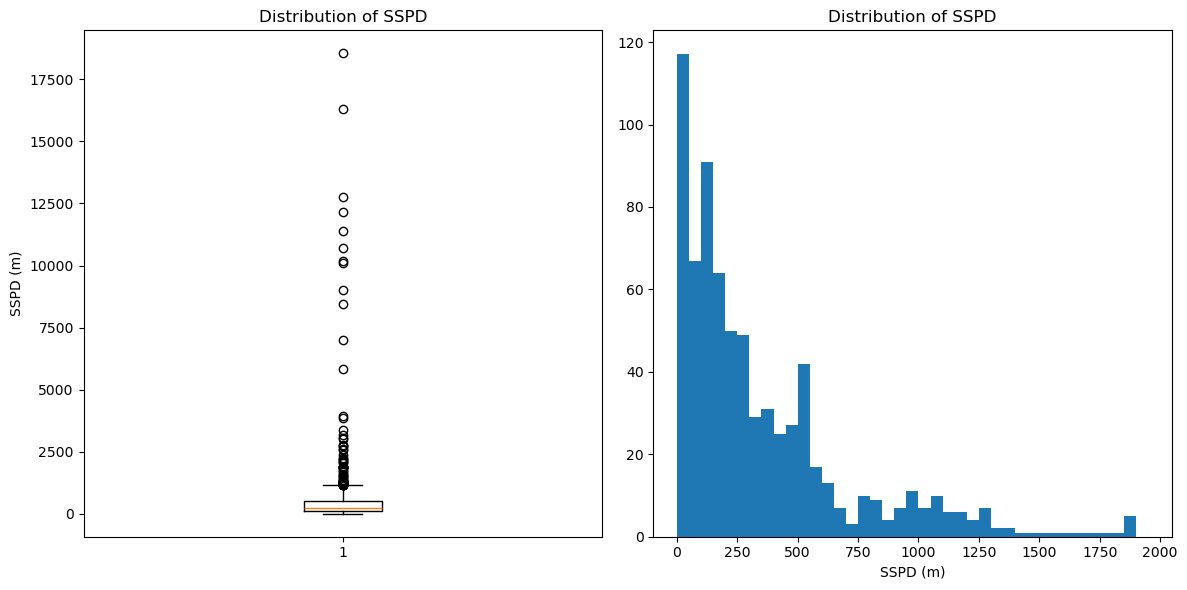

In [8]:
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions[0::2], test_trajectories, network, n_start_nodes=1, eval_mode='path')